In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

2023-06-04 13:50:22 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-06-04 13:50:22 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 6272 64.0 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.980519,0.981795,0.972647,0.982941,0.983447,0.985028,0.916442,0.915873,0.975771,0.987640
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.982845,0.983494,0.969335,0.980352,0.979375,0.985628,0.919008,0.932522,0.946315,0.962816
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.977261,0.981289,0.000000,0.000000,0.000000,0.000000,0.839730,0.857741,0.923794,0.943219
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.987944,0.987532,0.000000,0.000000,0.000000,0.000000,0.916442,0.915873,0.975771,0.987640
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.983483,0.981809,0.000000,0.000000,0.000000,0.000000,0.975984,0.979862,0.971879,0.987690


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID
model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



366


In [6]:
from collections import Counter
counter = Counter([c[:c.index('arg_types') - 1] for c in data_df.columns if 'arg_types' in c])
print(', '.join(f'{k}: {v}' for k, v in counter.items()))

adjacent: 18, adjacent_side_3: 4, agent_holds: 11, between: 2, distance: 26, in: 16, in_motion: 11, object_orientation: 6, on: 34, touch: 15


In [7]:
data_df.groupby('real')[[c for c in data_df.columns if 'length_of_then' in c]].mean()

,length_of_then_modals_1,length_of_then_modals_2,length_of_then_modals_3,length_of_then_modals_4,length_of_then_modals_5,length_of_then_modals_6,length_of_then_modals_7
real,,,,,,,
0,0.0,0.0,0.825753,0.078205,0.019083,0.0,0.0
1,0.0,0.0,0.816327,0.071429,0.020408,0.0,0.0


In [8]:
data_df[(data_df.real == 1) & (data_df.length_of_then_modals_2 == 1)]

,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score


## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.0880, std: 2.6408, bias: 0.0100


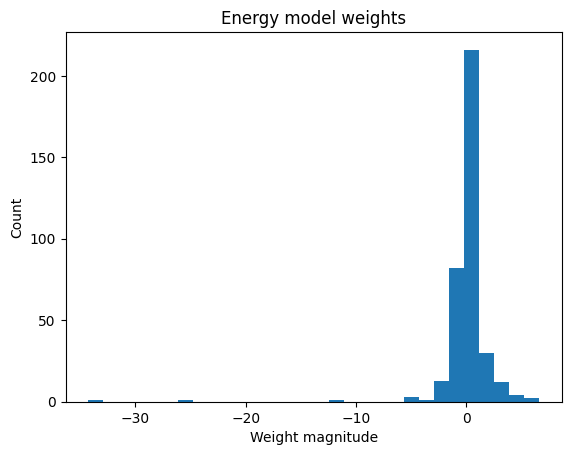

In [9]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [10]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (38, 10.38%) of the weights have magnitude < 0.0754
Approximately 25.0% (92, 25.14%) of the weights have magnitude < 0.2401
Approximately 50.0% (184, 50.27%) of the weights have magnitude < 0.6104
Approximately 75.0% (275, 75.14%) of the weights have magnitude < 1.0768
Approximately 90.0% (330, 90.16%) of the weights have magnitude < 1.9616
Approximately 95.0% (348, 95.08%) of the weights have magnitude < 2.9355
Approximately 99.0% (363, 99.18%) of the weights have magnitude < 6.6254


## Print the top K features most and least predictive of real games

In [11]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_7_score (-34.2861)
2. ast_ngram_constraints_n_7_score (-25.0627)
3. ast_ngram_setup_n_5_score (-11.5729)
4. all_variables_used (-5.4422)
5. ast_ngram_scoring_n_5_score (-5.0171)
6. all_preferences_used (-4.5642)
7. ast_ngram_terminal_n_5_score (-3.5236)
8. in_motion_arg_types_small_objects_constraints (-2.2473)
9. on_arg_types_furniture_large_objects_constraints (-2.2152)
10. section_doesnt_exist_setup (-1.9927)
11. mean_depth_setup_0 (-1.9828)
12. distance_arg_types_balls_balls_setup (-1.9477)
13. node_count_setup_0 (-1.9180)
14. max_width_setup_0 (-1.8531)
15. in_arg_types_receptacles_any_object_constraints (-1.8244)
16. max_width_scoring_0 (-1.8197)
17. all_variables_defined (-1.8193)
18. max_depth_setup_0 (-1.7931)
19. num_preferences_defined_3 (-1.7300)
20. distance_arg_types_furniture_ramps_constraints (-1.6583)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_pref_forall_correct_types_incorrect (6.6236)
2. pref_forall_used_incorrect (5.9608)
3. repeated_variables_found (5.0785)
4. two_number_operation_found (4.6314)
5. disjoint_seq_funcs_found (4.0388)
6. in_arg_types_other_constraints (3.9024)
7. pref_forall_pref_forall_correct_arity_incorrect (3.8679)
8. redundant_expression_found (3.6203)
9. distance_arg_types_other_constraints (3.2743)
10. adjacent_arg_types_other_constraints (3.0653)
11. in_motion_arg_types_room_features_constraints (2.9700)
12. agent_holds_arg_types_other_setup (2.9318)
13. in_motion_arg_types_other_setup (2.8939)
14. in_motion_arg_types_agent_constraints (2.7884)
15. agent_holds_arg_types_room_features_constraints (2.7325)
16. agent_holds_arg_types_agent_constraints (2.5965)
17. agent_holds_arg_types_other_constraints (2.5415)
18. in_motion_arg_types_other_constraints (2.5404)
19. agent_holds_arg_types_furniture_constraints (2.5261)
20. adjacent_arg_types_room_features_room_features_constraints (2.4700)

In [12]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if 'length_of_then' in c]

[('length_of_then_modals_1', tensor(0.0134)),
 ('length_of_then_modals_2', tensor(-0.0209)),
 ('length_of_then_modals_3', tensor(-0.2062)),
 ('length_of_then_modals_4', tensor(-0.4385)),
 ('length_of_then_modals_5', tensor(0.2489)),
 ('length_of_then_modals_6', tensor(-0.0584)),
 ('length_of_then_modals_7', tensor(0.0825))]

In [13]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if 'scoring_count_expression_repetitions' in c]

[('scoring_count_expression_repetitions_max', tensor(1.5389))]

In [14]:
data_df.groupby('real').distance_arg_types_furniture_receptacles_setup.describe()

,count,mean,std,min,25%,50%,75%,max
real,,,,,,,,
0,100352.0,0.011639,0.107255,0.0,0.0,0.0,0.0,1.0
1,98.0,0.010204,0.101015,0.0,0.0,0.0,0.0,1.0


In [15]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'disjoint_seq_funcs_found' in c]

[('disjoint_seq_funcs_found', tensor(4.0388))]

In [16]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

[('ast_ngram_full_n_7_score', tensor(-34.2861)),
 ('ast_ngram_setup_n_5_score', tensor(-11.5729)),
 ('ast_ngram_constraints_n_7_score', tensor(-25.0627)),
 ('ast_ngram_terminal_n_5_score', tensor(-3.5236)),
 ('ast_ngram_scoring_n_5_score', tensor(-5.0171))]

In [17]:
threshold = 5.0

fs = [c for i, c in enumerate(feature_columns) if 
      (weights[i].abs() < threshold) and ('arg_types' in c  or c.startswith('compositionality') or c.startswith('predicate_under_'))]

len(fs)

203

In [18]:
p = 0.1
s = data_df[data_df.real == 1][fs].mean().sort_values(ascending=False)
print(len(s[s > p]))
s[s > p].index

31


Index(['predicate_under_modal_once_agent_holds',
       'predicate_under_modal_once_in_motion',
       'predicate_under_modal_hold_agent_holds',
       'predicate_under_modal_hold_in_motion',
       'agent_holds_arg_types_balls_constraints',
       'in_motion_arg_types_balls_constraints', 'compositionality_structure_0',
       'predicate_under_modal_once_in',
       'in_arg_types_receptacles_balls_constraints',
       'compositionality_structure_1', 'compositionality_structure_2',
       'predicate_under_modal_once_on', 'compositionality_structure_3',
       'predicate_under_modal_while_hold_agent_holds',
       'predicate_under_modal_once_adjacent',
       'predicate_under_modal_while_hold_in_motion',
       'predicate_under_modal_while_hold_touch',
       'compositionality_structure_4',
       'in_motion_arg_types_blocks_constraints',
       'agent_holds_arg_types_blocks_constraints',
       'compositionality_structure_5',
       'on_arg_types_room_features_agent_constraints',
      

## Plot a histogram of the values for each of the and bottom K features

In [19]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

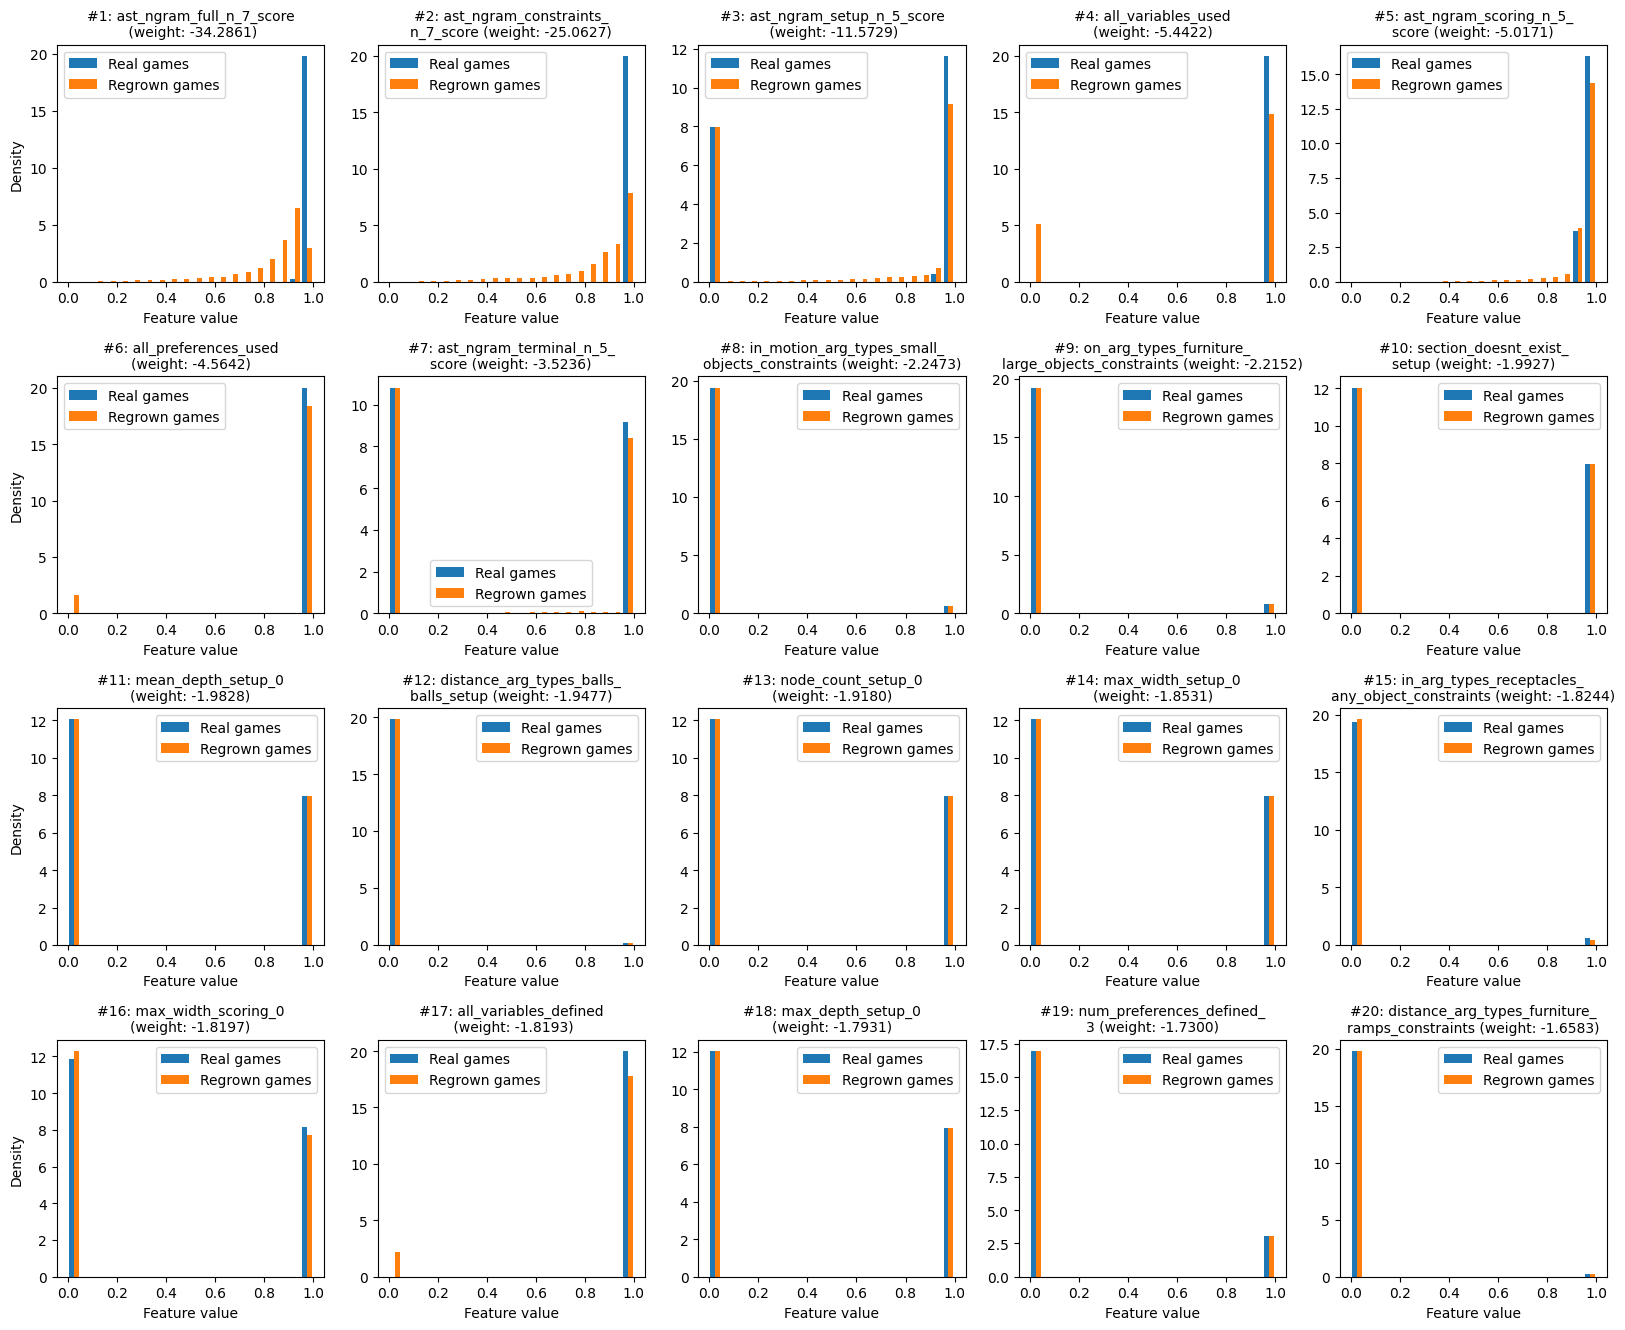

In [20]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

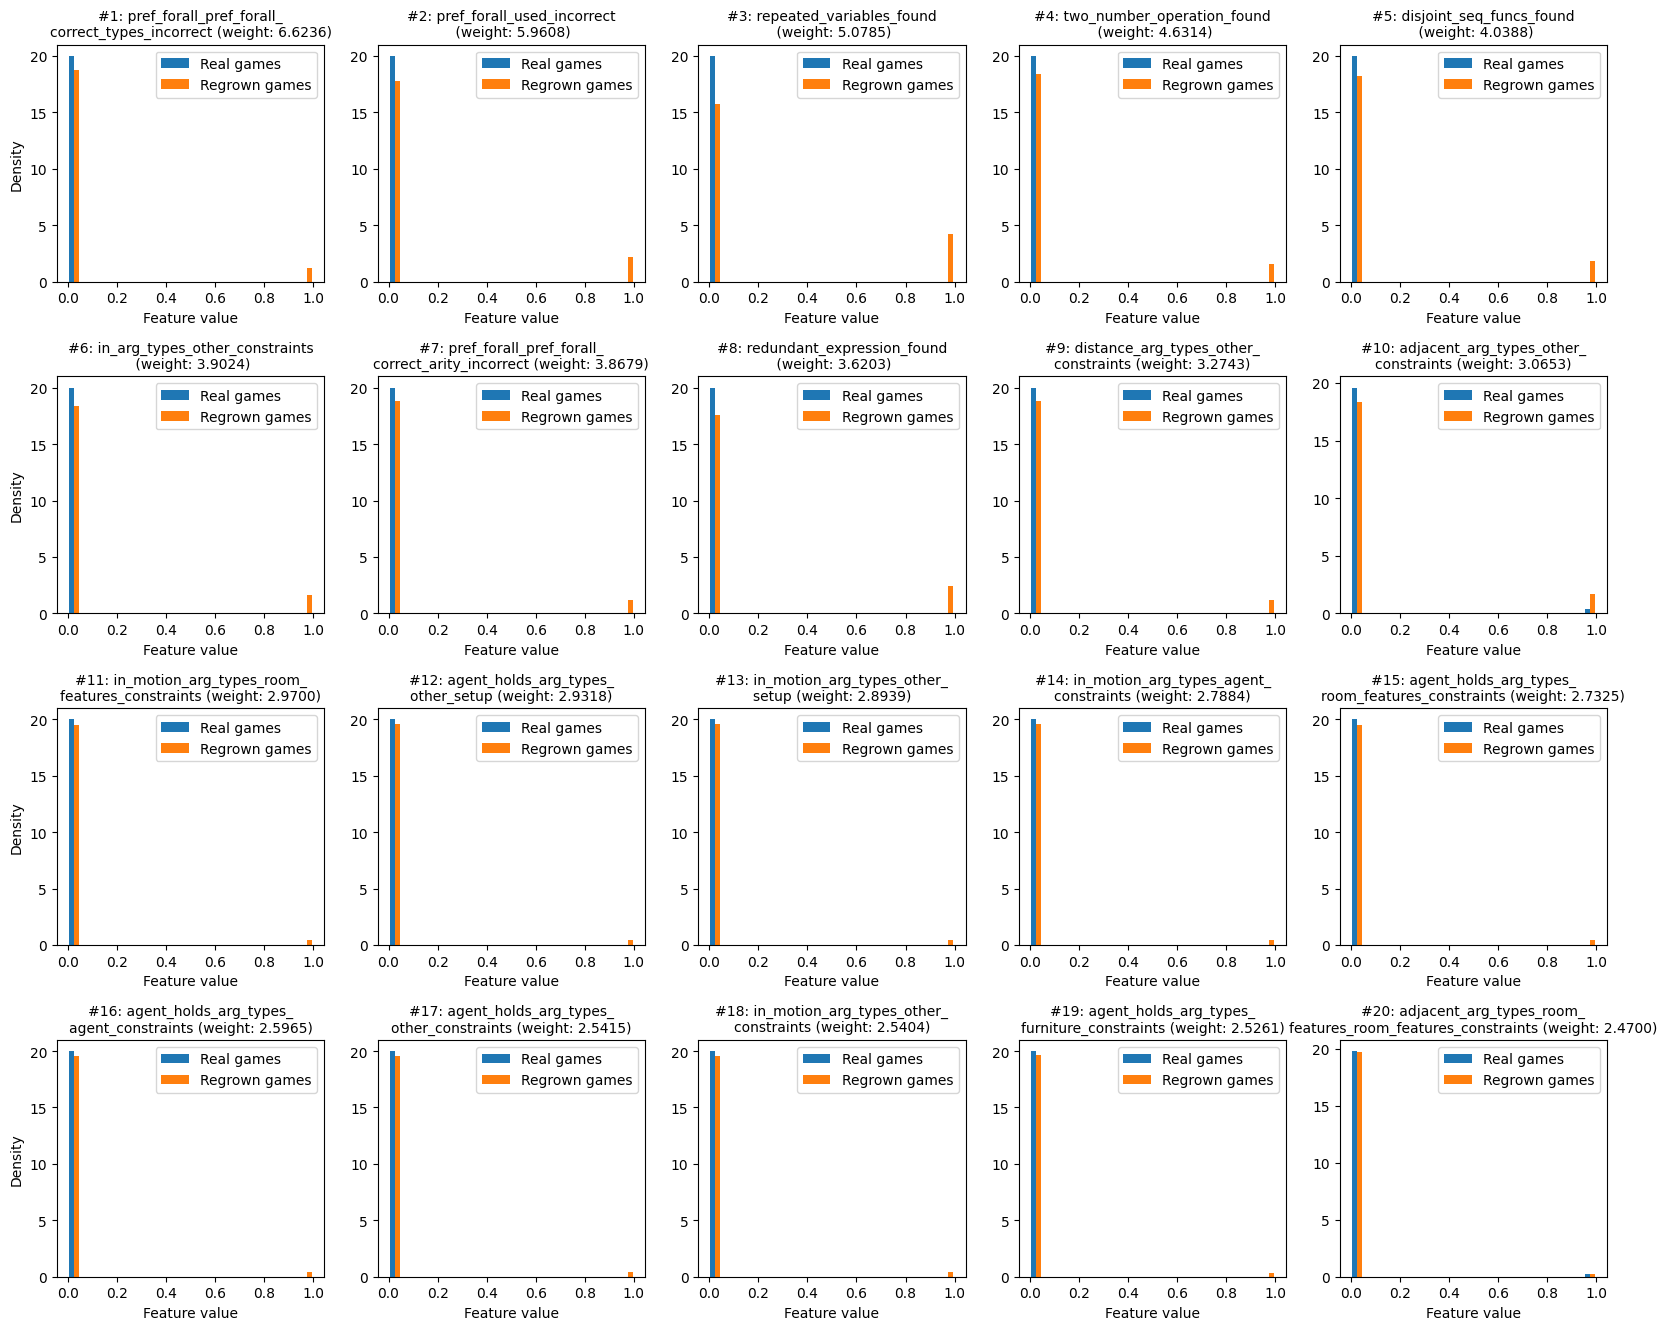

In [21]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [22]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [23]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

Real game scores: -93.7375 ± 1.0810, min = -97.7123, max = -91.8854


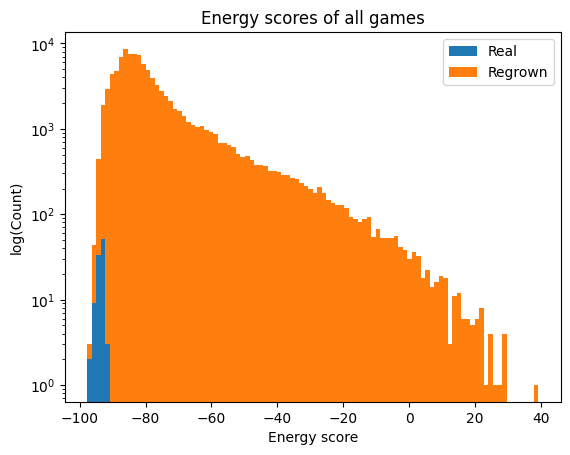

In [24]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [25]:
negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
torch.quantile(negatives_scores.ravel(), 0.2)

tensor(-86.9944)

In [ ]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [ ]:
torch.topk(score_diffs.ravel(), 10, largest=False)

In [ ]:
N_NEGATIVES = 20
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    
    display(Markdown('---'))

In [ ]:
data_df.loc[data_df.game_name == '5fefd5b2173bfbe890bc98ed-88-1012-nd-4-rd-14-rs-setup-sk-prior1', 'agent_holds_arg_types_other_setup']

In [ ]:
print(regrown_game_1024_texts[75 * 1024 + 1012])

## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_03_22.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

In [ ]:
ast = grammar_parser.parse(regrown_game_1024_texts[75 * 1024 + 1012])
r = featurizer.parse(ast, '', True, False)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

In [ ]:
r = featurizer.parse(ast, '', True, True)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

## Analyzing the role of different variables on the difficulty of the negative

In [ ]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [ ]:
negative_difficulty_df.head()

In [ ]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

In [ ]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

In [ ]:
def sem(x):
    return np.std(x) / np.sqrt(len(x))

regrowth_depth_impact = negative_difficulty_df.groupby('regrowth_depth').score_diff.agg(['mean', sem])

In [ ]:

plt.plot(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, 'o', linestyle='-')
plt.errorbar(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, regrowth_depth_impact['sem'].values, linestyle='None')
plt.xlabel('Regrown tree depth')
plt.ylabel('Mean energy difference (lower is harder)')
plt.title('Mean energy difference by regrown tree depth')
# regrowth_depth_impact['mean']

## Playing around with knocking out weights below some threshold

In [ ]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)


for threshold in (0, 0.1, 0.2, 0.3):
    weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    weights[weights.abs() < threshold] = 0
    model_copy = copy.deepcopy(cv_energy_model)
    model_copy.named_steps['fitness'].model.fc1.weight.data = weights.unsqueeze(0)  # type: ignore

    print(f'With threshold = {threshold}:')
    print(utils.evaluate_trained_model(model_copy, full_tensor, utils.default_multiple_scoring)) 
    print()